<a href="https://colab.research.google.com/github/snehasharma0807/eeg-epilepsy/blob/main/sept15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Imports
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#install and import packages
!pip install ipython-autotime
%load_ext autotime
# !pip install mne
import tensorflow as tf
from tensorflow import keras
# import os
# import mne
# from mne import create_info
# from mne.viz import plot_topomap
import numpy as np
import torch
import io
import matplotlib.pyplot as plt


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.6 MB/s eta 0:00:00
time: 13 s (started: 2023-09-16 05:25:36 +00:00)


In [ ]:
# @title Preprocessing Data: Functions
def getTimeFreqTopoData(EEG):
  times = []
  sec_increment = 10 * 60  # 10 minutes
  trange = np.arange(EEG.times[0], EEG.times[-1] + sec_increment, sec_increment)
  for i in np.arange(len(trange) - 1):
    times.append((trange[i], trange[i + 1]))

  bands = []
  frange = np.arange(80, 260, 10)  # Adjusted frequency range
  for i in np.arange(len(frange) - 1):
    bands.append((frange[i], frange[i + 1]))

  tf_topodata = []
  for t in times:
    print(t[0], '-', t[1])
    spectrum = EEG.compute_psd(tmin=t[0], tmax=t[1])
    freq_topodata = getTopoData(spectrum, bands)
    tf_topodata.append(freq_topodata)
  tf_topodata = np.stack(tf_topodata)
  return tf_topodata



def getTopoData(spectrum, bands):
  data = []
  for band in bands:
    data.append(getTopoBandData(spectrum, band))
  data = np.stack(data)
  return data

def getTopoBandData(spectrum, band):
  fig, ax1 = plt.subplots()
  fig.set_size_inches(2,2)
  spectrum.plot_topomap(axes=ax1, bands={'':band}, dB=True, cmap='gray', contours=0, outlines='head', sensors=False);
  fig.get_axes()[1].remove() #remove colorbar
  fig.get_axes()[0].set_title(None)

  with io.BytesIO() as buff:
    fig.savefig(buff, format='raw')
    buff.seek(0)
    data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
  w, h = fig.canvas.get_width_height()
  im = data.reshape((int(h), int(w), -1))
  im = im[30:155, 25:150, 0]
  plt.close()
  return im

time: 1.47 ms (started: 2023-08-11 01:53:23 +00:00)


In [ ]:
# @title Preprocessing Data
subjects = ["24", "25", "26", "27", "28", "29", "30"]

for subj in subjects:
  #loading data
  sample_data_folder =("/content/drive/MyDrive/projectcode")
  sample_data_raw_file = os.path.join(sample_data_folder,'sub-'+ subj + '_ses-01_task-hfo_eeg.edf')
  raw = mne.io.read_raw_edf(sample_data_raw_file,preload = True)
  raw.load_data()

  #check channels
  print(raw.info.ch_names)
  raw.drop_channels(["A1", "A2", "Cz2", 'T1', 'T2'], on_missing = 'ignore')
  print(raw.info.ch_names)

  #resample data to 500 hz
  resampled = raw.resample(500)

  data = resampled.get_data()
  info = create_info(ch_names=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'], sfreq=500, ch_types='eeg')
  info.set_montage('standard_1020')

  EEG = mne.io.RawArray(data, info)

  tf_topodata = getTimeFreqTopoData(EEG)  # output shape = [# time windows X # freq bands X # vert pixels X # horz pixels]
  print(tf_topodata.shape)
  output_directory = "/content/drive/MyDrive/projectcode/newtensors/"
  tftopo_fileName =str(subj) + '_tf_topodata.tensor'
  output = os.path.join(output_directory, tftopo_fileName)
  torch.save(tf_topodata, output)
  EEG = None
  tf_topodata = None
  raw = None
  resampled = None

  print("Done with " + subj)

In [2]:
# @title Getting Data Ready for ML
import torch

def getTensorFromFile(subject):
  tftopo_fileName = "/content/drive/MyDrive/projectcode/newtensors/"+subject+"_tf_topodata.tensor"
  tf_topodata = torch.load(tftopo_fileName)
  return tf_topodata


subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"]

tensors = [getTensorFromFile(subj) for subj in subjects]
tensors[12], tensors[19], tensors[29] = tensors[12][:-1, :, :, :], tensors[19][:-1, :, :, :], tensors[29][:-1, :, :, :]

#right shape
tensors = [np.transpose(t, (0, 2, 3, 1)) for t in tensors]

#normalize data
tensors = [t.astype("float32")/255.0 for t in tensors]

#convert into correct shape
data = [array[:, 0:, :, :] for array in tensors]
data = np.concatenate(data, axis=0) #np.stack

print(data.shape)
print(len(tensors))
print(tensors[0].shape)

(535, 125, 125, 17)
30
(18, 125, 125, 17)
time: 17 s (started: 2023-09-16 05:26:07 +00:00)


In [3]:
# @title Dimensionality Reduction With PCA
from sklearn.decomposition import PCA

# reshape data for pca input
num_samples, height, width, num_channels = data.shape
data_reshaped = data.reshape(num_samples * height * width, num_channels)


# initialize pca
pca = PCA(n_components=3)

# fit pca
reduced_data = np.empty((num_samples * height * width, 3))
reduced_data = pca.fit_transform(data_reshaped)
weights = pca.components_
print(weights.T)

# reshape lower-dimension data
reduced_data = reduced_data.reshape(num_samples, height, width, 3)
print(reduced_data.shape)

[[-0.22356296 -0.471189   -0.22342156]
 [-0.23052254 -0.41868916 -0.28025246]
 [-0.23433472 -0.34668684 -0.25049   ]
 [-0.23986264 -0.2463876   0.13285102]
 [-0.24259247 -0.19449542  0.18891051]
 [-0.24440156 -0.11630807  0.23942694]
 [-0.24344397 -0.05249225  0.49588966]
 [-0.24364868  0.00607721  0.5009591 ]
 [-0.24811992  0.09687752  0.12836011]
 [-0.2482276   0.14155935  0.06818728]
 [-0.24671577  0.19275182 -0.05489539]
 [-0.24513777  0.13458222 -0.23480639]
 [-0.24604023  0.1700784  -0.23607124]
 [-0.24743046  0.23192468 -0.09897083]
 [-0.24698915  0.24469021 -0.12200386]
 [-0.24662717  0.2500793  -0.14910485]
 [-0.24390878  0.27895266 -0.13911349]]
(535, 125, 125, 3)
time: 24.3 s (started: 2023-09-16 05:26:43 +00:00)


In [4]:
# @title Feature Extraction with CNN
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# load vgg model
base_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(125, 125, 3))

# freeze weights of pretrained layers
for layer in base_vgg.layers:
  layer.trainable = False

x = Dense(400, activation = 'relu')(base_vgg.output)
x = Dense(40, activation = 'relu')(x)
x = Dense(10, activation = 'relu')(x)
print(x.shape)
feature_extractor = Model(inputs=base_vgg.input, outputs=Flatten()(x))

# extract features
features = feature_extractor.predict(reduced_data)

print(features.shape)

80134624/80134624 [==============================] - 1s 0us/step
(None, 3, 3, 10)
17/17 [==============================] - 154s 9s/step
(535, 90)
time: 3min 24s (started: 2023-09-16 05:27:55 +00:00)


In [5]:
# @title KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=20, random_state=0)
cluster_assignments = kmeans.fit_predict(features)
print(cluster_assignments.shape)


# x = cluster_assignments[:324]
# x = x.reshape((18, 18))
# print(x)

# x = cluster_assignments[324:337]
# x = x.reshape((1, 13))
# print(x)

# x = cluster_assignments[337:]
# x = x.reshape((11, 18))
# print(x)


x = np.where(cluster_assignments == 0)[0]
print(x.shape)
x = np.where(cluster_assignments == 1)[0]
print(x.shape)
x = np.where(cluster_assignments == 2)[0]
print(x.shape)

(535,)
(196,)
(263,)
(76,)
time: 771 ms (started: 2023-09-16 05:32:29 +00:00)


In [ ]:
print(cluster_assignments)

outer_list = [[i] * 18 for i in range(30)]
print("!!!!!!!!!!", outer_list[18])
outer_list[18] = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
flat_list = [item for sublist in outer_list for item in sublist]
print(np.array(flat_list))

[1 1 1 1 1 0 2 1 2 0 1 1 0 2 0 0 0 0 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 2 1 2 2
 0 2 2 2 0 2 2 2 2 2 2 2 2 0 0 0 0 1 1 2 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 2 2
 2 2 2 0 1 0 1 0 0 2 1 1 1 0 2 0 0 0 2 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 2 0 1 0 0 0 0 0 0 0 2 2 0 2 2 2 2 0 1 2 2 2 0 2 2 0 0 0
 2 2 2 0 0 0 0 0 0 1 0 2 2 0 0 1 0 0 0 2 1 0 1 0 0 1 2 1 2 2 2 2 0 1 2 2 2
 2 1 2 2 2 1 2 2 1 2 2 1 1 2 0 0 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 2 2 1 2 1 1 2 1 1 0 0 0 2 2 2 2 2 2 0 2 1 0 0 0 0 0 0 0 0 2 2 2 2 0
 2 0 2 2 2 0 2 0 2 2 0 0 2 2 2 0 2 0 0 2 0 0 2 2 2 0 0 0 0 0 0 0 2 0 0 0 0
 0 2 2 2 2 0 0 2 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 1
 1 2 2 2 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 2 2 2 2 2 2 1 2 2 2 2 0 2 0 2
 2 2 0 0 0 0 0 2 2 0 2 0 2 2 2 2 2 2 2 0 2 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0
 0 0 1 2 2 1 0 1 2 1 2 2 2 1 1 2 2 2 2 1 0 0 0 0 0 0 2 1 1 1 1 0 1 1 1 2 2
 0 2 2 0 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 1 0 1 0 0 0 1 2 2 2 2 1 0 0 0 1 2
 0 0 2 2 0 0 2 0 0 0 2 2 

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


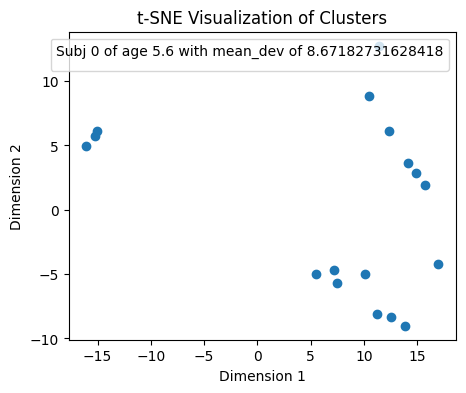

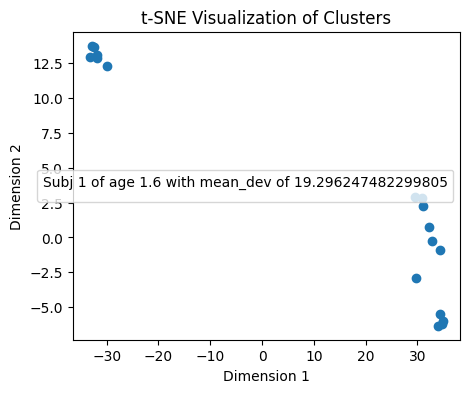

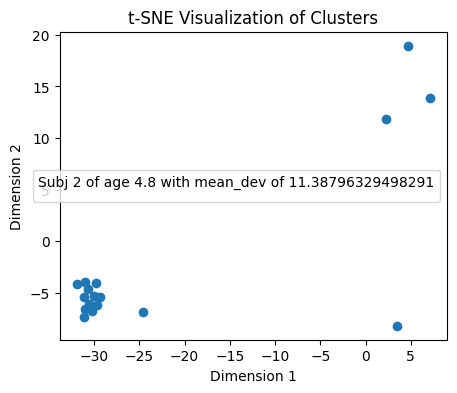

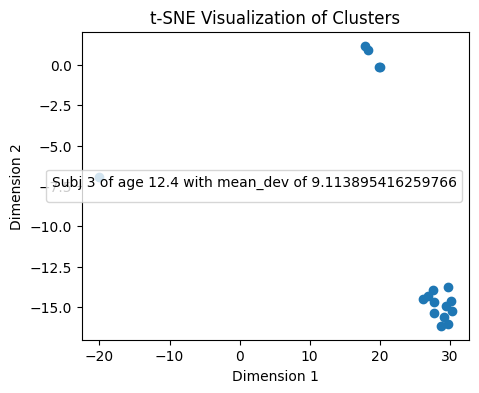

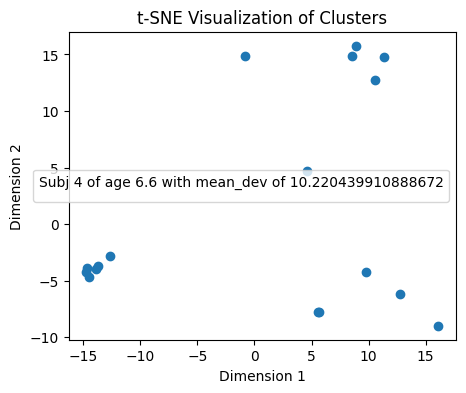

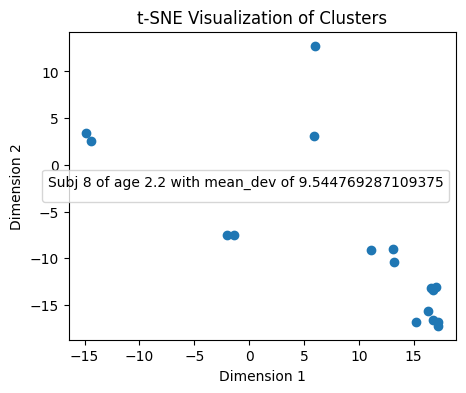

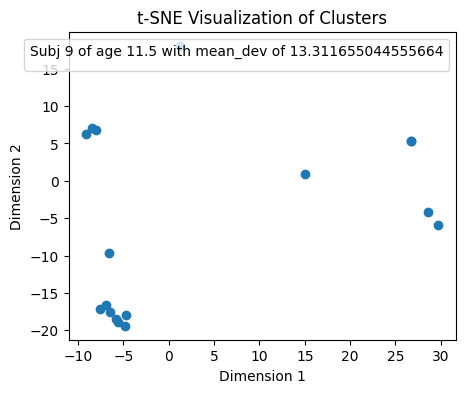

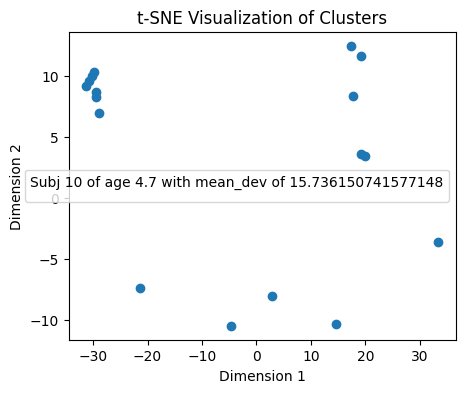

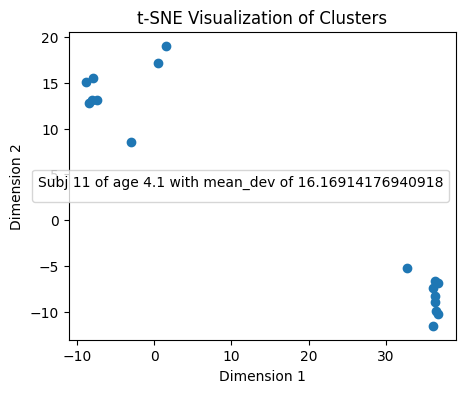

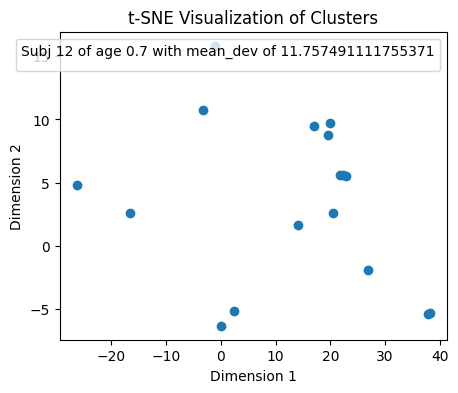

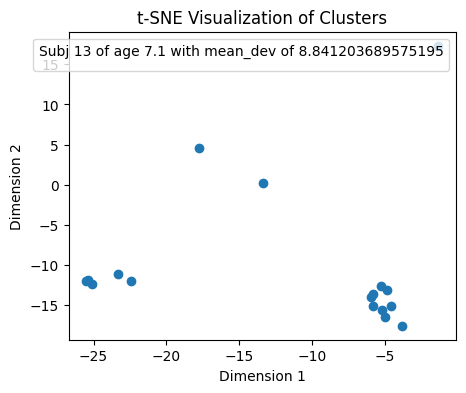

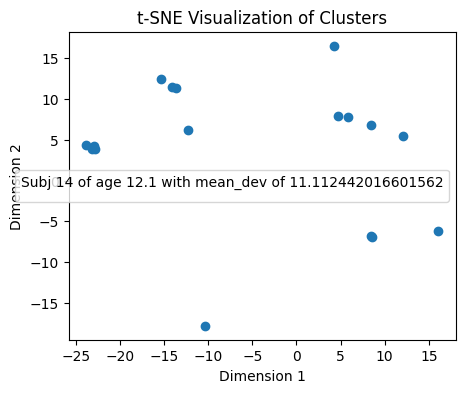

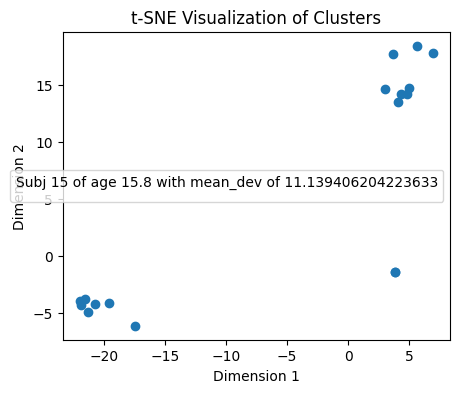

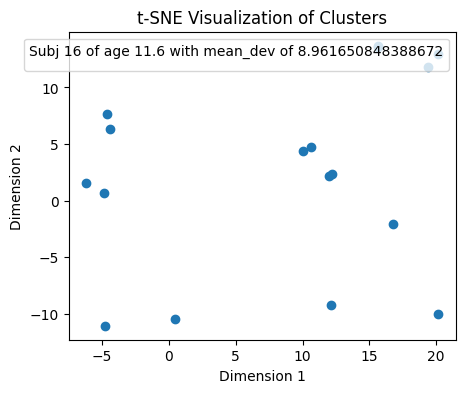

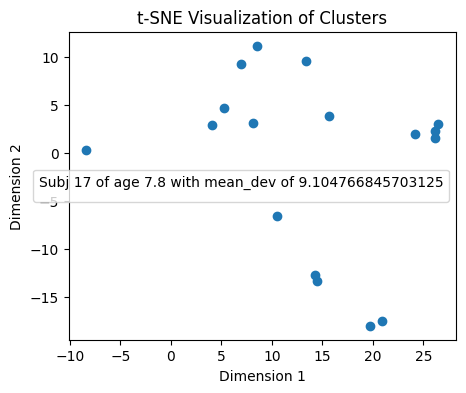

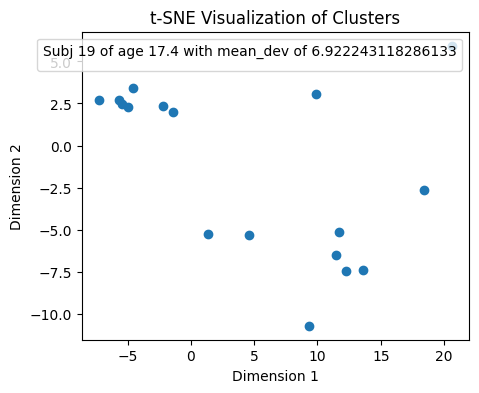

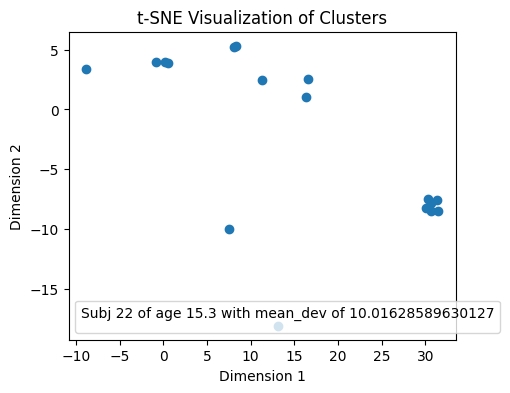

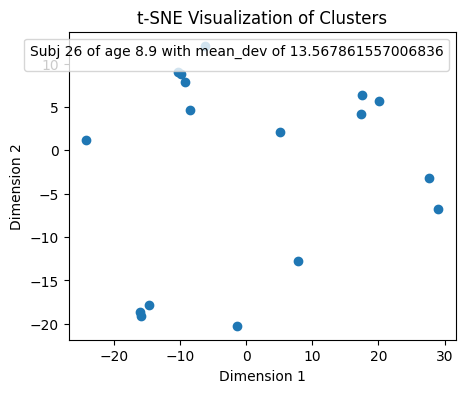

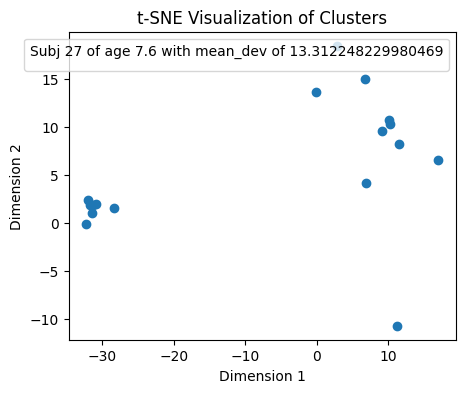

time: 20.1 s (started: 2023-09-16 05:35:40 +00:00)


In [8]:
# @title Visualize Clusters with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ages = [5.6, 1.6, 4.8, 12.4, 6.6, 3.8, 4.9, 5.7, 2.2, 11.5, 4.7, 4.1, 0.7, 7.1, 12.1, 15.8, 11.6, 7.8, 1.5, 17.4, 0.8, 7.7, 15.3, 4.8, 6.1, 2.0, 8.9, 7.6, 15.8, 15.7]
mapping = []
all_means = []
for i in range(18):
  mapping.append((i * 18, i * 18 + 17))

mapping.append((324, 336))

for i in range(19, 30):
  mapping.append((337 + (i-19) * 18, (i-19) * 18 + 337 + 17))

# Assuming 'features' are your extracted features and 'cluster_assignments' are the cluster labels

tsne = TSNE(n_components=2, random_state=0)  # Use n_components=2 for 2D visualization
embedded_data = tsne.fit_transform(features)

# Create a scatter plot in 2D with cluster coloring
subj = 0
for map in mapping:
  plt.figure(figsize=(5, 4))
  scatter = plt.scatter(embedded_data[map[0]:map[1], 0], embedded_data[map[0]:map[1], 1])
  plt.title('t-SNE Visualization of Clusters')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  mean_dev = np.mean(np.std(embedded_data[map[0]:map[1]], axis = 0))
  all_means.append(mean_dev)

  # Add colorbar
  legend = plt.legend(*scatter.legend_elements(), title=f'Subj {subj} of age {ages[subj]} with mean_dev of {mean_dev}')
  plt.show()
  subj += 1

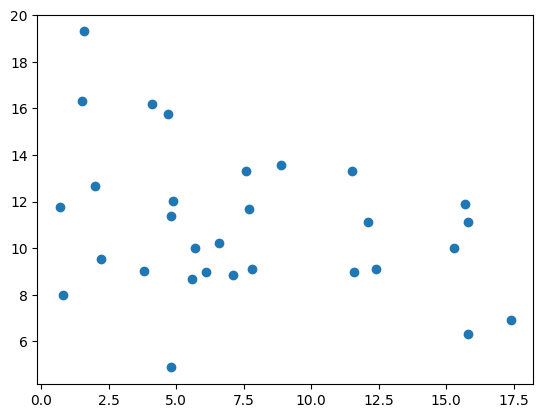

time: 215 ms (started: 2023-09-16 05:39:43 +00:00)


In [15]:
# @title Graph of Subject Age over Data Point Similarity/Standard Deviation
plt.scatter(ages, all_means)
plt.show()

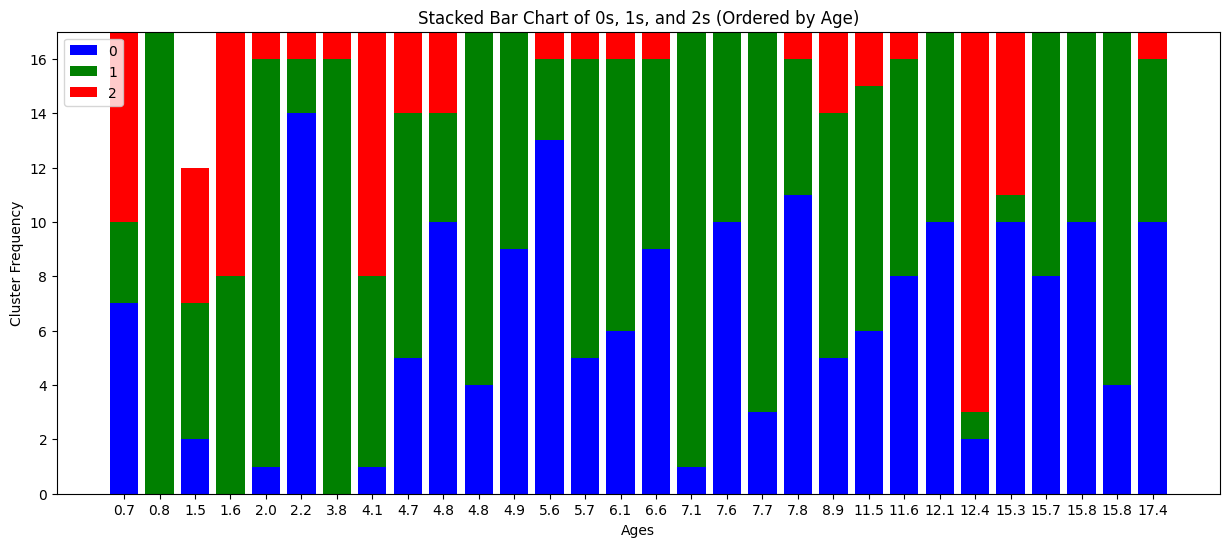

time: 1.67 s (started: 2023-09-16 05:52:15 +00:00)


In [27]:
allss = []
for map in mapping:
  cluster_indices = cluster_assignments[map[0]:map[1]]
  allss.append(list(cluster_indices))

# Sort both lists based on ages
sorted_data = [x for _, x in sorted(zip(ages, allss))]
sorted_ages = sorted(ages)

# Initialize counters for each category (0, 1, 2)
count_0 = np.zeros(30)
count_1 = np.zeros(30)
count_2 = np.zeros(30)

# Iterate through each list in sorted_data and count occurrences
for i, lst in enumerate(sorted_data):
    count_0[i] = lst.count(0)
    count_1[i] = lst.count(1)
    count_2[i] = lst.count(2)

# Create the stacked bar chart
x = np.arange(len(sorted_data))  # X-axis values (bar positions)

# Create figure
plt.figure(figsize=(15, 6))

# Plot the bars
plt.bar(x, count_0, label='0', color='blue')
plt.bar(x, count_1, bottom=count_0, label='1', color='green')
plt.bar(x, count_2, bottom=count_0+count_1, label='2', color='red')

# Customize the chart
plt.xlabel('Ages')
plt.ylabel('Cluster Frequency')
plt.title('Stacked Bar Chart of 0s, 1s, and 2s (Ordered by Age)')
plt.xticks(x, [str(age) for age in sorted_ages])  # Set x-axis labels to ages
plt.legend()

# Show the chart
plt.show()


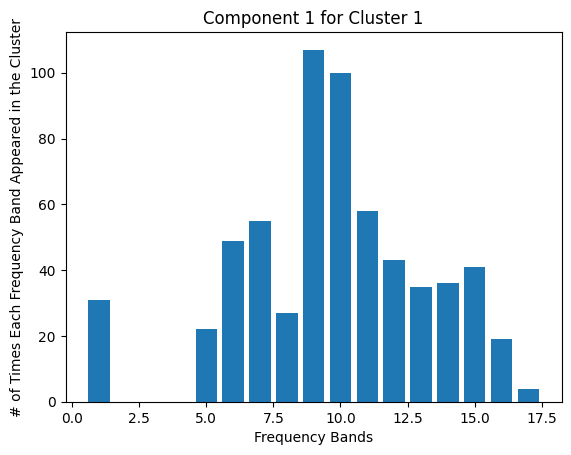

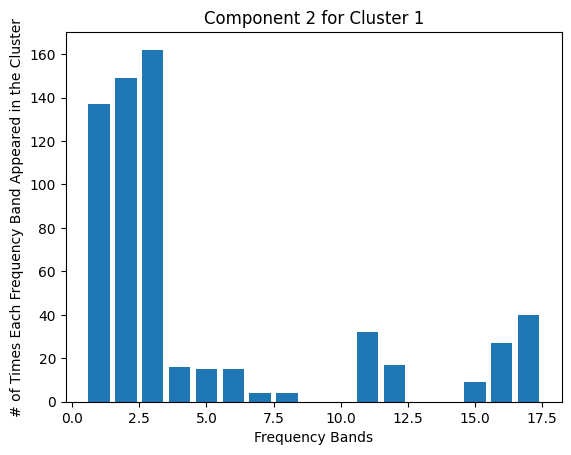

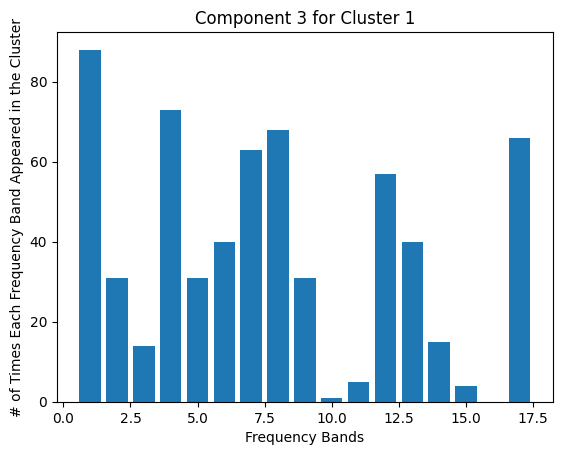

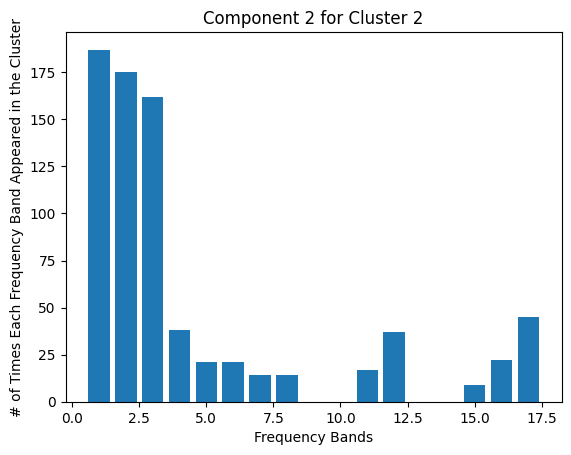

time: 6.4 s (started: 2023-08-30 00:11:51 +00:00)


In [ ]:
# @title Displaying the Main Frequency Bands Per PCA Component in Each Cluster
import os
mapping = []
for i in range(18):
  mapping.append((i * 18, i * 18 + 17))

mapping.append((324, 336))

for i in range(19, 30):
  mapping.append((337 + (i-19) * 18, (i-19) * 18 + 337 + 17))



for cluster in range(3):
  cluster_indices = np.where(cluster_assignments == cluster)[0]

  for component_num in range(3):
    subjs_in_cluster = []

    for index in cluster_indices:
      for num in range(len(mapping)):
        start, end = mapping[num]
        if index >= start and index <= end:
          subjs_in_cluster.append(num)

    # subjs_in_cluster = set(subjs_in_cluster)

    comps_in_cluster = {}

    for subj in subjs_in_cluster:
      for rank in all_ranks[subj][:3, component_num]:
        if rank in comps_in_cluster:
          comps_in_cluster[rank] += 1
        else:
          comps_in_cluster[rank] = 1

    keys = list(comps_in_cluster.keys())
    values = list(comps_in_cluster.values())

    plt.bar(keys, values)
    plt.xlabel('Frequency Bands')
    plt.ylabel('# of Times Each Frequency Band Appeared in the Cluster')
    plt.title(f'Component {component_num + 1} for Cluster {cluster + 1}')

    output_directory = "/content/drive/MyDrive/projectcode/comp_photos_2"
    output_file = "comp_num" + str(component_num + 1) + "-cluster_num" + str(cluster + 1) + ".png"
    output = os.path.join(output_directory, output_file)
    plt.savefig(output)

    plt.show()

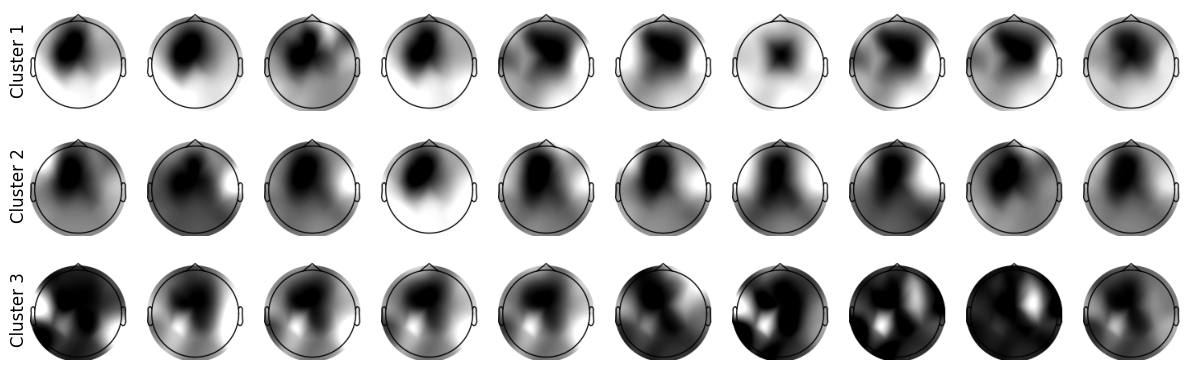

time: 2.07 s (started: 2023-08-23 20:46:07 +00:00)


In [ ]:
# @title View 10 Images From Each Cluster
num_clusters = 3

fig, axes = plt.subplots(num_clusters, 10, figsize=(12, 4))
for cluster_num in range(num_clusters):
    images = []
    # find indices of data points in the current cluster
    cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    # show 5 images from each cluster
    for i, idx in enumerate(cluster_indices[:10]):
        ax = axes[cluster_num, i]
        image = data[idx, :, :, 0]
        images.append(image)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
    average_image = np.mean(images, axis = 0)
    ax.imshow(average_image, cmap='gray')
    ax.axis('off')

# label each cluster
for r in range(num_clusters):
    ax = axes[r, 0]
    ax.text(-0.2, 0.5, f'Cluster {r + 1}', transform=ax.transAxes,
            rotation=90, va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

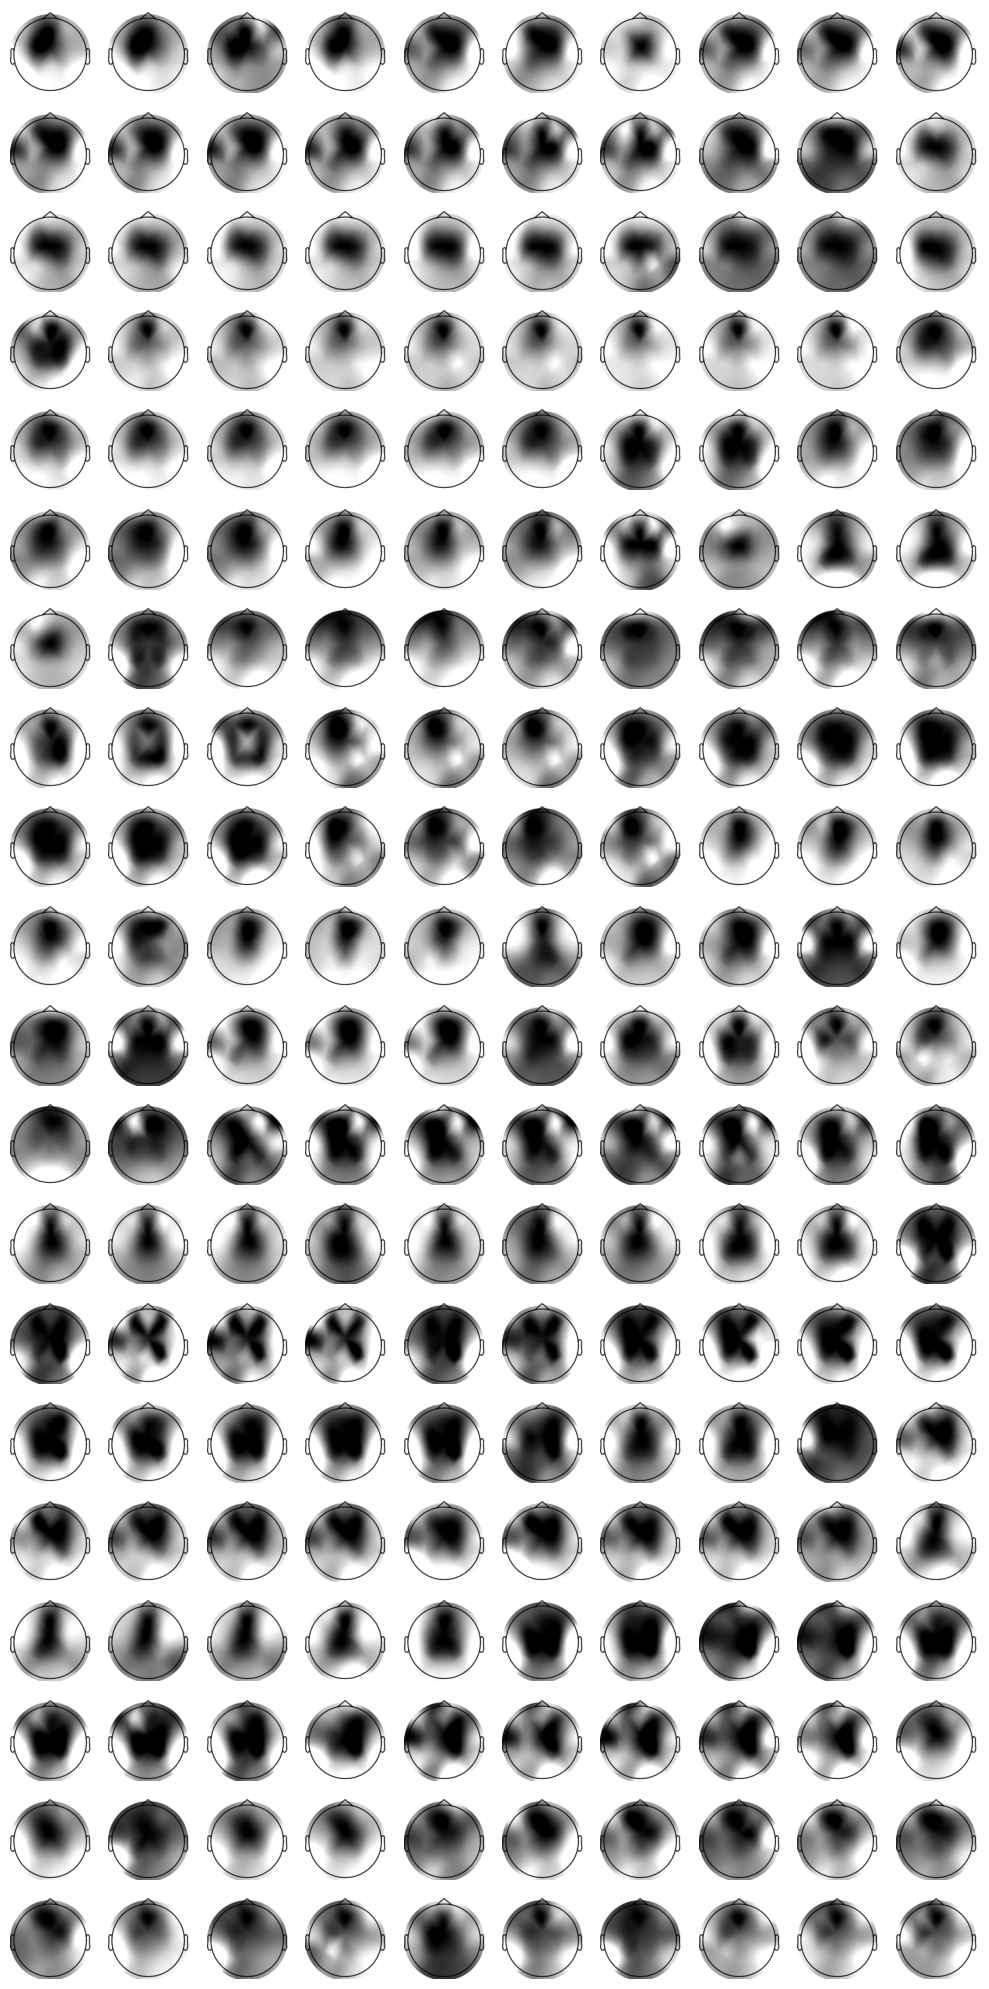

time: 6.96 s (started: 2023-08-30 00:17:28 +00:00)


In [ ]:
# @title All Images From Cluster 0
cluster_num = 0
cluster_indices = np.where(cluster_assignments == cluster_num)[0]
num_rows = int(cluster_indices.shape[0] / 10)
num_cols = 10


fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

# show 10 images from each cluster
for i, idx in enumerate(cluster_indices[:num_rows*num_cols]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    image = data[idx, :, :, 0]
    ax.imshow(image, cmap='gray')
    ax.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
# @title All Images From Cluster 1
cluster_num = 1
cluster_indices = np.where(cluster_assignments == cluster_num)[0]
num_rows = int(cluster_indices.shape[0] / 10)
num_cols = 10


fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

# show 10 images from each cluster
for i, idx in enumerate(cluster_indices[:num_rows*num_cols]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    image = data[idx, :, :, 0]
    ax.imshow(image, cmap='gray')
    ax.axis('off')


plt.tight_layout()
plt.show()

time: 10.9 s (started: 2023-08-30 00:19:13 +00:00)


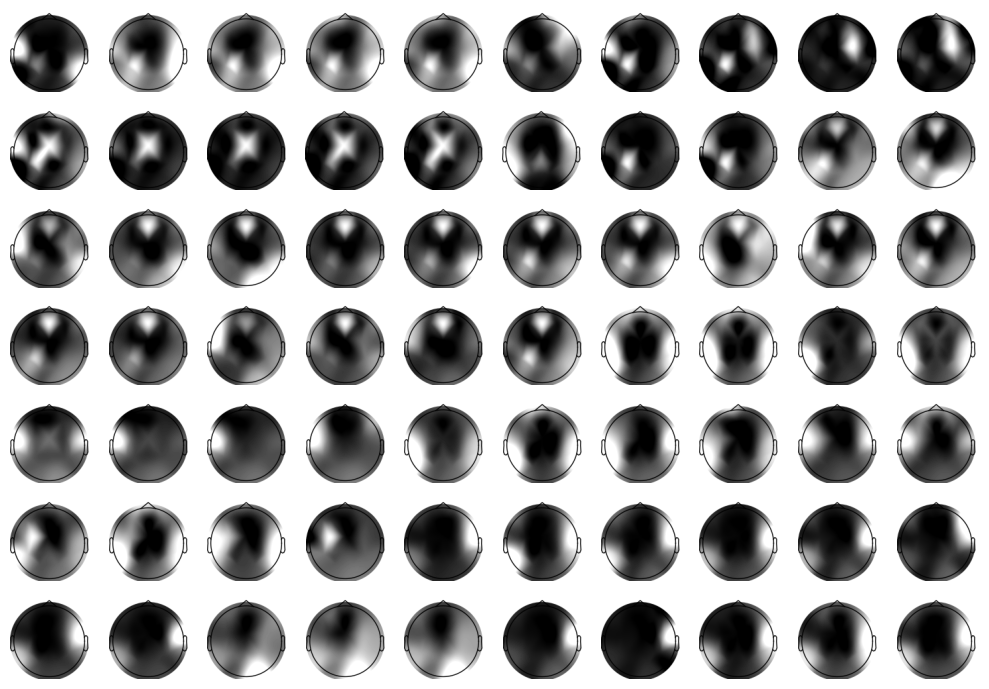

time: 3.46 s (started: 2023-08-30 00:18:11 +00:00)


In [ ]:
# @title All Images From Cluster 2
cluster_num = 2
cluster_indices = np.where(cluster_assignments == cluster_num)[0]
num_rows = int(cluster_indices.shape[0] / 10)
num_cols = 10


fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

# show 10 images from each cluster
for i, idx in enumerate(cluster_indices[:num_rows*num_cols]):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    image = data[idx, :, :, 0]
    ax.imshow(image, cmap='gray')
    ax.axis('off')


plt.tight_layout()
plt.show()

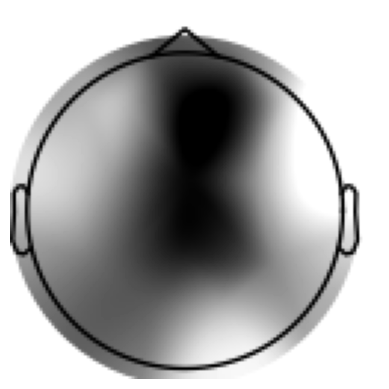

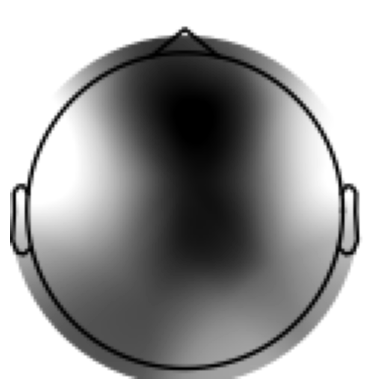

time: 383 ms (started: 2023-08-30 00:18:24 +00:00)


In [ ]:
# @title Average Image Per Cluster
num_clusters = 3

for cluster_num in range(num_clusters):
    images = []
    # find indices of data points in the current cluster
    cluster_indices = np.where(cluster_assignments == cluster_num)[0]
    all_indices_length = cluster_indices.shape[0]
    # show 5 images from each cluster
    for i, idx in enumerate(cluster_indices[:all_indices_length - 1]):
        image = data[idx, :, :, 0]
        images.append(image)
    average_image = np.mean(images, axis = 0)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()